Test Kinetic Modeling Fitting functions
============
This toolbox contains several kinetic modeling and quantification methods, as well as simulation tools and phantoms, which are demonstrated in this notebook.

In [1]:
% setup hyperpolarized-mri-toolbox

cd ../
startup
cd 'kinetic_modeling'

loading optim
loading image
loading io
loading statistics


In [2]:
fit_function = @fit_pyr_kinetics;
plot_fits = 1;

In [3]:
% Test values
Tin = 0; Tacq = 48; TR = 3; N = Tacq/TR;
R1P = 1/25; R1L = 1/25; kPL = 0.05; std_noise = 0.01;

 gamma variate input function - most realistic 


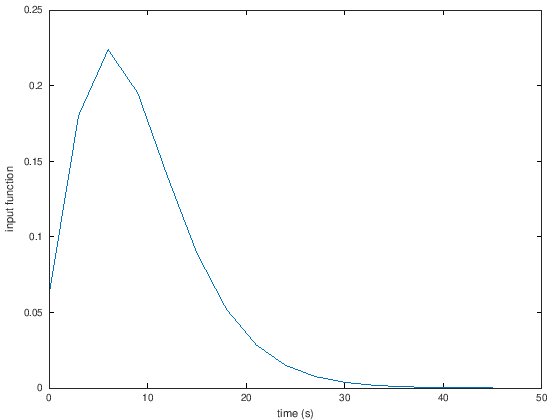

In [4]:
% setup input function

input_function = zeros(1,N);
input_condition = 1; % choose from various simulated starting conditions
switch input_condition
    case 1
        disp(' gamma variate input function - most realistic ')
        Tarrival = 0;  Tbolus = 12;
        input_function = realistic_input_function(N, TR, Tarrival, Tbolus);
        Mz0 = [0,0]; 
    case 2
        disp('boxcar input function') 
        Tbolus = 12;  Tarrival = 0;
        Ibolus = [1:round(Tbolus/TR)] + round(Tarrival/TR);
        Rinj = 1/Tbolus; % normalize for a total magnetization input = 1
        Mz0 = [0,0]; input_function(Ibolus) =  Rinj*TR;
    case 3
        disp('no input function')
        Mz0 = [1.5,0]; % no input function
    case 4
        disp('no input function, delayed start')
        Tin = 6; Mz0 = Tin; % no input function, delayed start
end

t = [0:N-1]*TR + Tin;

plot(t,input_function)
xlabel('time (s)'), ylabel('input function')

constant, single-band


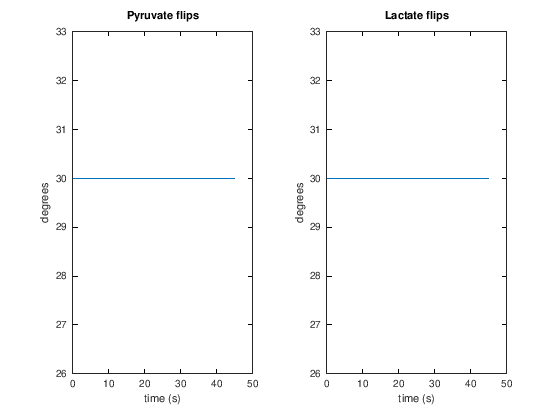

In [5]:
% Choose a flip angle scheme

flip_scheme = 1;

switch flip_scheme
    case 1
        flips = ones(2,N)*30*pi/180;  flip_description = 'constant, single-band';
    case 2
        flips = repmat([20;35]*pi/180,[1 N]);  flip_description = 'constant, multi-band';
    case 3
        k12 = 0.05; % for variable flip angle designs
        flips = [vfa_const_amp(N, pi/2, exp(-TR * ( k12))); ... % T1-effective pyruvate variable flip angles
            vfa_opt_signal(N, exp(-TR * ( R1L)))]; % max lactate SNR variable flip angle
        flip_description = 'max lactate SNR variable flip, multi-band';
    case 4
        flips = [vfa_const_amp(N, pi/2, exp(-TR * ( k12))); ... % T1-effective variable flip angle
            vfa_const_amp(N, pi/2, exp(-TR * ( - k12)))];
        flip_description = 'T1-effective variable flip';
    case 5
        flips = [vfa_const_amp(N, pi/2, exp(-TR * (k12))); ... % saturation recovery
             ones(1,N)*pi/2];
        flip_description = 'saturation recovery';
end

disp(flip_description)

subplot(121) , plot(t, squeeze(flips(1,:,:))*180/pi)
title('Pyruvate flips')
xlabel('time (s)'), ylabel('degrees')
subplot(122) , plot(t, squeeze(flips(2,:,:))*180/pi)
title('Lactate flips')
xlabel('time (s)'), ylabel('degrees')


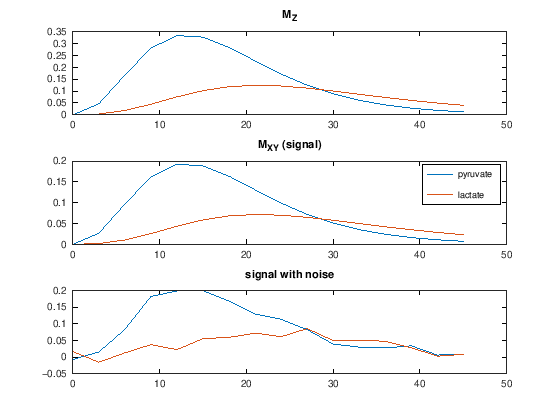

In [6]:
% generate simulated data
noise_S = randn([2 N])*std_noise;  % same noise for all flip schedules
[Mxy, Mz] = simulate_Nsite_model(Mz0, [R1P R1L], [kPL 0], flips, TR, input_function);
% add noise
Sn = Mxy + noise_S;

subplot(311), plot(t, Mz)
title('M_Z')
subplot(312), plot(t, Mxy)
title('M_{XY} (signal)')
legend('pyruvate','lactate')
subplot(313), plot(t, Sn)
title('signal with noise')


Now we have created a simulated hyperpolarized signals, let's test fitting!

First, we will try just fitting the kPL value, leaving the relaxation rates (T1s) fixed.  This is a common assumption that helps with fitting stability.

Note a couple key points
* the fit_pyr_kinetics() function is an "input-less" model, so the pyruvate signal itself is used to determine the input, and no input function is fit.
* there are results for both zero-mean Gaussian noise fitting (when you have phased data), as well as for using magnitude data (Rician noise distribution)

In [7]:
% parameter estimates
R1P_est = 1/25; R1L_est = 1/25; kPL_est = .02;

% setup params_fixed and params_est structures required by the fitting functions
% fix relaxation rates
params_fixed.R1P = R1P_est; params_fixed.R1L = R1L_est;
% estimated kPL, and use this value as initial guess
params_est.kPL = kPL_est;

==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.05 S0_L = 0.00012 
no noise


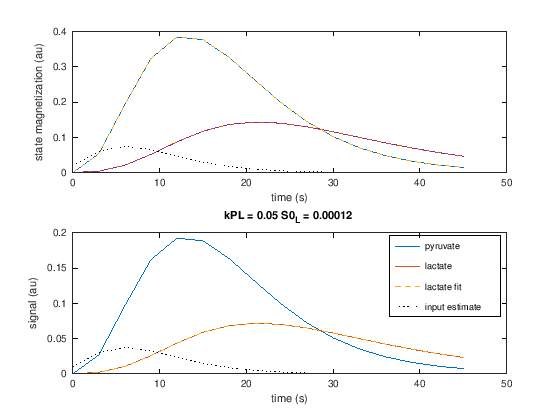

In [8]:
% noiseless
[params_fit Sfit] = fit_function(Mxy, TR, flips, params_fixed, params_est, [], plot_fits);
disp('no noise')


==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.045 S0_L = 0.0089 
added noise, real-valued data


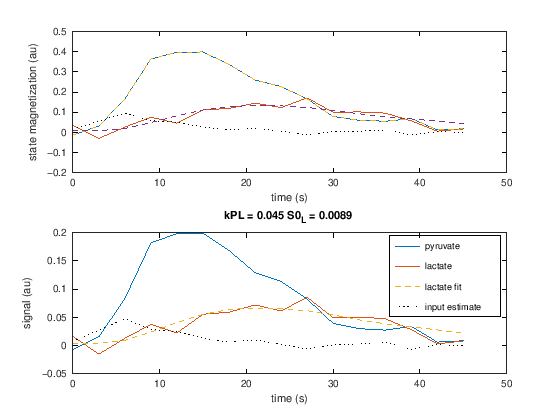

In [9]:
% added noise, real-valued (not magnitude) data
[params_fit_noise Sfit_noise] = fit_function(Sn, TR, flips, params_fixed, params_est, [], plot_fits);
disp('added noise, real-valued data')

==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.038 S0_L = 9.4e-07 
added noise, magnitude data


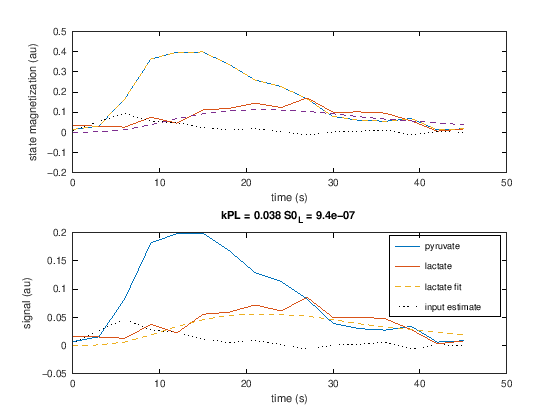

In [10]:
% added noise, magnitude data
% NOTE that this requires an estimate of the noise

[params_fit_noise_mag Sfit_noise_mag] = fit_function(abs(Sn), TR, flips, params_fixed, params_est, std_noise, plot_fits);
disp('added noise, magnitude data')

The chosen T1 for the metabolic products has a substantial impact on the resulting conversion rate parameters.  (Pyruvate T1 values have very small effect on results with inputless fitting approach.)  This can be addressed by fitting the T1 values, but this comes at the expense of increased variability (less stability) in the fitting

In this next example, we add fitting of the lactate T1 value, where T1 = 1/R1L

In [44]:
% parameter estimates
R1P_est = 1/25; R1L_est = 1/25; kPL_est = .02;

clear params_fixed params_est 
% setup params_fixed and params_est structures required by the fitting functions
% fix pyruvate relaxation rates
params_fixed.R1P = R1P_est;
% estimate kPL and t1 of lactate
params_est.kPL = kPL_est; params_est.R1L = R1L_est;
% set constraints on lactate T1:
params_est.R1L_lb = 1/40;
params_est.R1L_ub = 1/15;


==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.05 R1L = 0.04 S0_L = 6.9e-05 
no noise


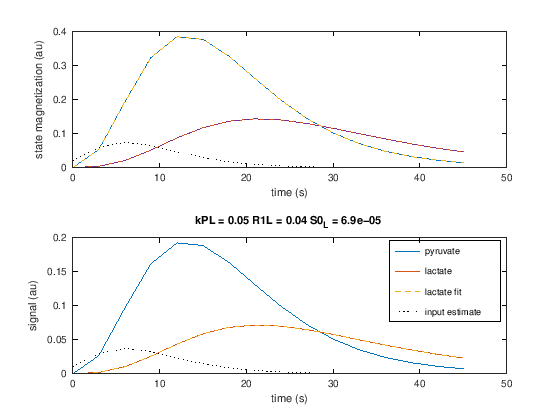

In [46]:
% noiseless
[params_fit Sfit] = fit_function(Mxy, TR, flips, params_fixed, params_est, [], plot_fits);
disp('no noise')


==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.053 R1L = 0.035 S0_L = 0.0054 
added noise, real-valued data


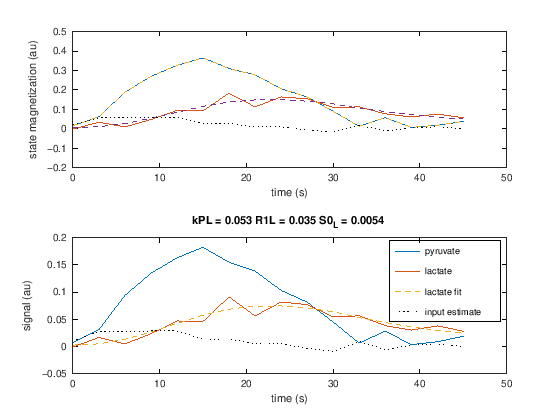

In [47]:
% added noise, real-valued (not magnitude) data
[params_fit_noise Sfit_noise] = fit_function(Sn, TR, flips, params_fixed, params_est, [], plot_fits);
disp('added noise, real-valued data')

==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.052 R1L = 0.048 S0_L = -0.0075 
added noise, magnitude data


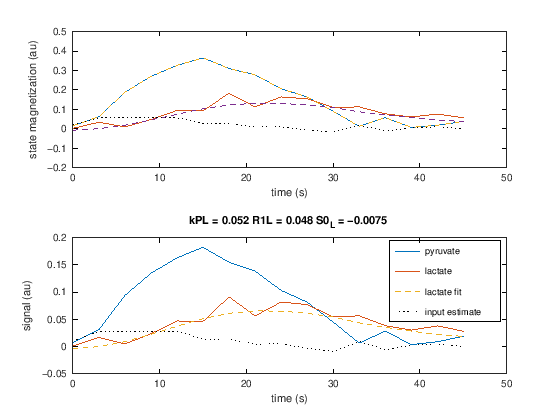

In [48]:
% added noise, magnitude data
% NOTE that this requires an estimate of the noise

[params_fit_noise_mag Sfit_noise_mag] = fit_function(abs(Sn), TR, flips, params_fixed, params_est, std_noise, plot_fits);
disp('added noise, magnitude data')

The model can be extended to be applied to generation of multiple metabolic products, ie pyruvate to lactate, bicarbonate, and alanine.  

In [49]:
% Test values
Tin = 0; Tacq = 48; TR = 3; N = Tacq/TR;
R1P = 1/25; R1L = 1/25; R1B = 1/15; R1A = 1/25;
kPL = 0.05; kPB = 0.03; kPA = 0.02;
std_noise = 0.005;

In [57]:
% update flip angles (apply same to all products)
flips_4site = cat(1, flips, repmat( flips(2,:), [2 1 1]));
% update initial magnetization
Mz0_4site = [Mz0, Mz0(2), Mz0(2)];

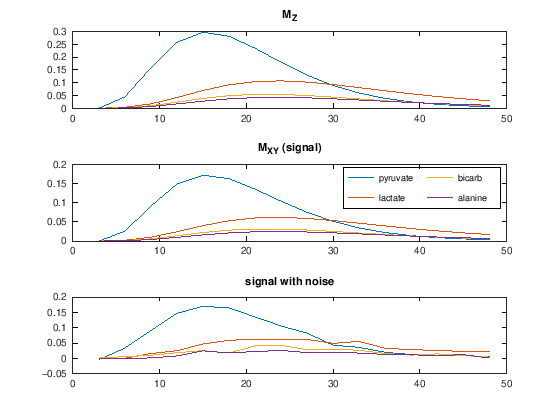

In [59]:
% generate simulated data
noise_S = randn([4 N])*std_noise;  % same noise for all flip schedules
[Mxy, Mz] = simulate_Nsite_model(Mz0_4site, [R1P R1L R1B R1A], [kPL 0; kPB 0; kPA 0], ...
    flips_4site, TR, input_function);
% add noise
Sn = Mxy + noise_S;

subplot(311), plot(t, Mz)
title('M_Z')
subplot(312), plot(t, Mxy)
title('M_{XY} (signal)')
legend('pyruvate','lactate', 'bicarb', 'alanine')
subplot(313), plot(t, Sn)
title('signal with noise')


In [63]:
% parameter estimates
R1P_est = 1/25; R1L_est = 1/25; R1B_est = 1/15; R1A_est = 1/25;
kPL_est = .02; kPB_est = .02; kPA_est = .02;

% setup params_fixed and params_est structures required by the fitting functions
clear params_fixed params_est 
% fix relaxation rates
params_fixed.R1P = R1P_est; params_fixed.R1L = R1L_est; params_fixed.R1B = R1B_est; params_fixed.R1A = R1A_est;
% estimated kPX, and use this value as initial guess
params_est.kPL = kPL_est; params_est.kPB = kPB_est; params_est.kPA = kPA_est;
R1P_est = 1/25; R1L_est = 1/25; kPL_est = .02;


==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.05 kPB = 0.03 kPA = 0.02 S0_L = -4.1e-07 S0_B = -2.6e-07 S0_A = -1.6e-07 
no noise


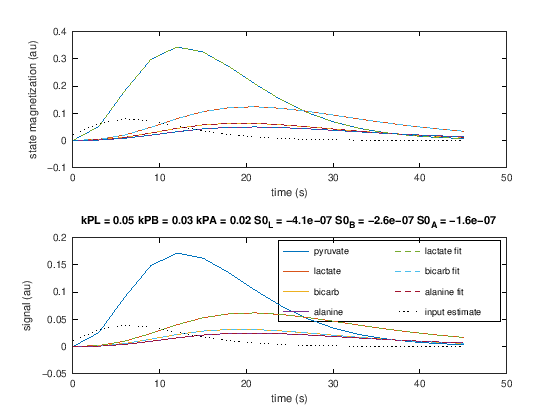

In [71]:
% noiseless
[params_fit Sfit] = fit_function(Mxy, TR, flips_4site, params_fixed, params_est, [], plot_fits);
disp('no noise')


==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.051 kPB = 0.033 kPA = 0.019 S0_L = 0.0023 S0_B = 0.0063 S0_A = 0.00035 
added noise, real-valued data


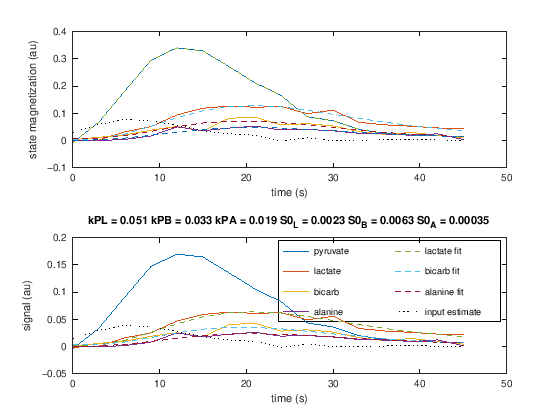

In [72]:
% added noise, real-valued (not magnitude) data
[params_fit_noise Sfit_noise] = fit_function(Sn, TR, flips_4site, params_fixed, params_est, [], plot_fits);
disp('added noise, real-valued data')

==== Computing parameter map ====
    fit_pyr_kinetics at line 200 column 36
kPL = 0.047 kPB = 0.021 kPA = -1.1e-05 S0_L = -0.0018 S0_B = -0.0025 S0_A = 0.00044 
added noise, magnitude data


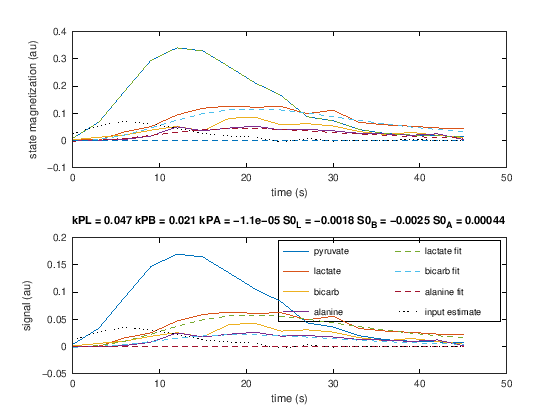

In [73]:
% added noise, magnitude data
% NOTE that this requires an estimate of the noise

[params_fit_noise_mag Sfit_noise_mag] = fit_function(abs(Sn), TR, flips_4site, params_fixed, params_est, std_noise, plot_fits);
disp('added noise, magnitude data')